In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
# ML Models
#import lightgbm as lgb
#from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report
#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
# Feature Importance 
import shap

In [2]:
train_singapore = pd.read_csv('datasets/train_pisa2018_singapore.csv')
test_singapore = pd.read_csv('datasets/test_pisa2018_singapore.csv')

In [3]:
train_singapore.head(2)

,CNTSTUID,GRADE,AGE,ISCEDL,ISCEDO,PAREDINT,HISEI,IMMIG,REPEAT,MMINS,...,ICTCLASS,ICTOUTSIDE,WVARSTRR,GENDER,MATH,SCIENCE,READ,TOTALSCORE,"Is_MISCED_5A,6","Is_FISCED_5A,6"
0,70201292.0,0.0,15.75,ISCED level 3,General,14.5,73.91,Native,Did not repeat a grade,225.0,...,0.2379,0.3583,52.0,1,634.0078,603.2218,674.4429,637.224167,0,0
1,70206843.0,0.0,16.00,ISCED level 3,General,16.0,65.12,Native,Did not repeat a grade,315.0,...,-0.2254,-0.6237,7.0,1,686.3560,682.3456,708.6816,692.461067,0,1


In [4]:
test_singapore.head(2)

,CNTSTUID,GRADE,AGE,ISCEDL,ISCEDO,PAREDINT,HISEI,IMMIG,REPEAT,MMINS,...,ICTCLASS,ICTOUTSIDE,WVARSTRR,GENDER,MATH,SCIENCE,READ,TOTALSCORE,"Is_MISCED_5A,6","Is_FISCED_5A,6"
0,70202942.0,0.0,16.00,ISCED level 3,General,12.0,75.54,Native,Did not repeat a grade,200.0,...,1.0418,1.3503,4.0,0,545.0969,456.2449,425.9418,475.7612,0,0
1,70206829.0,-1.0,15.83,ISCED level 3,General,12.0,29.81,Native,Repeated a grade,300.0,...,0.0733,0.7719,71.0,1,581.2635,592.3786,569.7755,581.1392,0,0


In [5]:
train_singapore.isnull().sum().sum(), test_singapore.isnull().sum().sum()

(0, 0)

In [6]:
train_singapore.set_index('CNTSTUID', inplace=True)
test_singapore.set_index('CNTSTUID', inplace=True)

In [9]:
train_singapore[['TOTALSCORE']].describe()

,TOTALSCORE
count,5274.000000
mean,558.157485
std,92.696588
min,232.334533
25%,497.631708
50%,568.097283
75%,627.357517
max,784.566967


In [10]:
def assign_performance_level(data):
    if data <= 558:
        return '0' #lowperformance 
    else:
         return '1'  #highperformance 

In [11]:
train_singapore['PISALEVEL'] = train_singapore['TOTALSCORE'].apply(assign_performance_level)
test_singapore['PISALEVEL'] = test_singapore['TOTALSCORE'].apply(assign_performance_level)

In [12]:
train_singapore['PISALEVEL'].value_counts()

1    2867
0    2407
Name: PISALEVEL, dtype: int64

In [13]:
train_singapore['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

1    54.36
0    45.64
Name: PISALEVEL, dtype: float64

In [14]:
test_singapore['PISALEVEL'].value_counts()

1    692
0    625
Name: PISALEVEL, dtype: int64

In [15]:
test_singapore['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

1    52.54
0    47.46
Name: PISALEVEL, dtype: float64

In [20]:
#Assemble our X and y variables
X_train =train_singapore[['PAREDINT', 'HISEI', 'ESCS', 'UNDREM', 'METASUM', 'METASPAM',
       'HOMEPOS', 'HEDRES', 'ICTRES', 'JOYREAD', 'SCREADCOMP',
       'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'AWACOM', 'Is_FISCED_5A,6', 'ISCEDL', 'ISCEDO', 'IMMIG', 'REPEAT', 'GENDER']]
X_train = pd.get_dummies(columns=['Is_FISCED_5A,6', 'ISCEDL', 'ISCEDO', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_train)
y_train = train_singapore['PISALEVEL']

X_test =test_singapore[['PAREDINT', 'HISEI', 'ESCS', 'UNDREM', 'METASUM', 'METASPAM',
       'HOMEPOS', 'HEDRES', 'ICTRES', 'JOYREAD', 'SCREADCOMP',
       'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'AWACOM', 'Is_FISCED_5A,6', 'ISCEDL', 'ISCEDO', 'IMMIG', 'REPEAT', 'GENDER']]
X_test = pd.get_dummies(columns=['Is_FISCED_5A,6', 'ISCEDL', 'ISCEDO', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_test)
y_test = test_singapore['PISALEVEL']

In [21]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

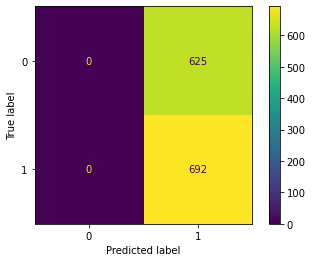

In [22]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier()
baseline_model.fit(X_train_sc, y_train)
baseline_preds = baseline_model.predict(X_test_sc)
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds);

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, baseline_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       625
           1       0.53      1.00      0.69       692

    accuracy                           0.53      1317
   macro avg       0.26      0.50      0.34      1317
weighted avg       0.28      0.53      0.36      1317



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [26]:
logreg =LogisticRegression()


parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 100]}]

logreg_gr = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

logreg_gr.fit(X_train_sc, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['none', 'l2']}, {'C': [1, 10, 100]}],
             scoring='accuracy')

In [27]:
preds= logreg_gr.predict(X_test_sc)

In [28]:
pd.DataFrame(logreg_gr.cv_results_).sort_values('rank_test_score').head(5)[['params','mean_test_score']]

,params,mean_test_score
3,{'C': 10},0.78252
1,{'penalty': 'l2'},0.78233
2,{'C': 1},0.78233
0,{'penalty': 'none'},0.78214
4,{'C': 100},0.78214


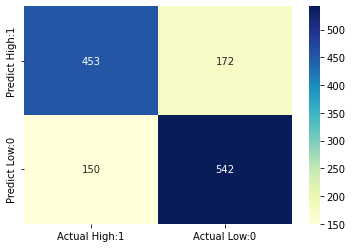

In [29]:
cm = confusion_matrix(y_test, preds)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74       625
           1       0.76      0.78      0.77       692

    accuracy                           0.76      1317
   macro avg       0.76      0.75      0.75      1317
weighted avg       0.76      0.76      0.76      1317



In [31]:
logreg =LogisticRegression(random_state= 42, C= 10)
logreg.fit(X_train_sc, y_train)
preds= logreg.predict(X_test_sc)
pd.Series(logreg.coef_[0], index = X_train.columns).sort_values(ascending=False)

METASPAM                    0.754834
METASUM                     0.414691
JOYREAD                     0.374557
GCSELFEFF                   0.240618
UNDREM                      0.222472
ESCS                        0.200080
HEDRES                      0.180076
IMMIG_Second-Generation     0.160129
AWACOM                      0.155313
PAREDINT                    0.120406
HISEI                       0.081038
Is_FISCED_5A,6_1            0.076242
HOMEPOS                     0.067718
ISCEDL_ISCED level 3        0.055352
ICTRES                      0.029489
SCREADDIFF                  0.026976
IMMIG_Native                0.003902
ISCEDL_ISCED level 4        0.003296
REPEAT_Repeated a  grade   -0.232840
SCREADCOMP                 -0.253673
GENDER_1                   -0.286065
PISADIFF                   -0.542408
dtype: float64

In [32]:
# coefficient dataframe
logreg_coef = pd.DataFrame(data=logreg.coef_,columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in logreg_coef[0]]

# Assign the color_list to new column
logreg_coef['color'] = color

logreg_coef.head()

,0,color
METASPAM,0.754834,blue
METASUM,0.414691,blue
JOYREAD,0.374557,blue
GCSELFEFF,0.240618,blue
UNDREM,0.222472,blue


In [33]:
# Select the highest values whether negative or positive
abs(logreg_coef[0]).sort_values(ascending=False)[:10].index

Index(['METASPAM', 'PISADIFF', 'METASUM', 'JOYREAD', 'GENDER_1', 'SCREADCOMP',
       'GCSELFEFF', 'REPEAT_Repeated a  grade', 'UNDREM', 'ESCS'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

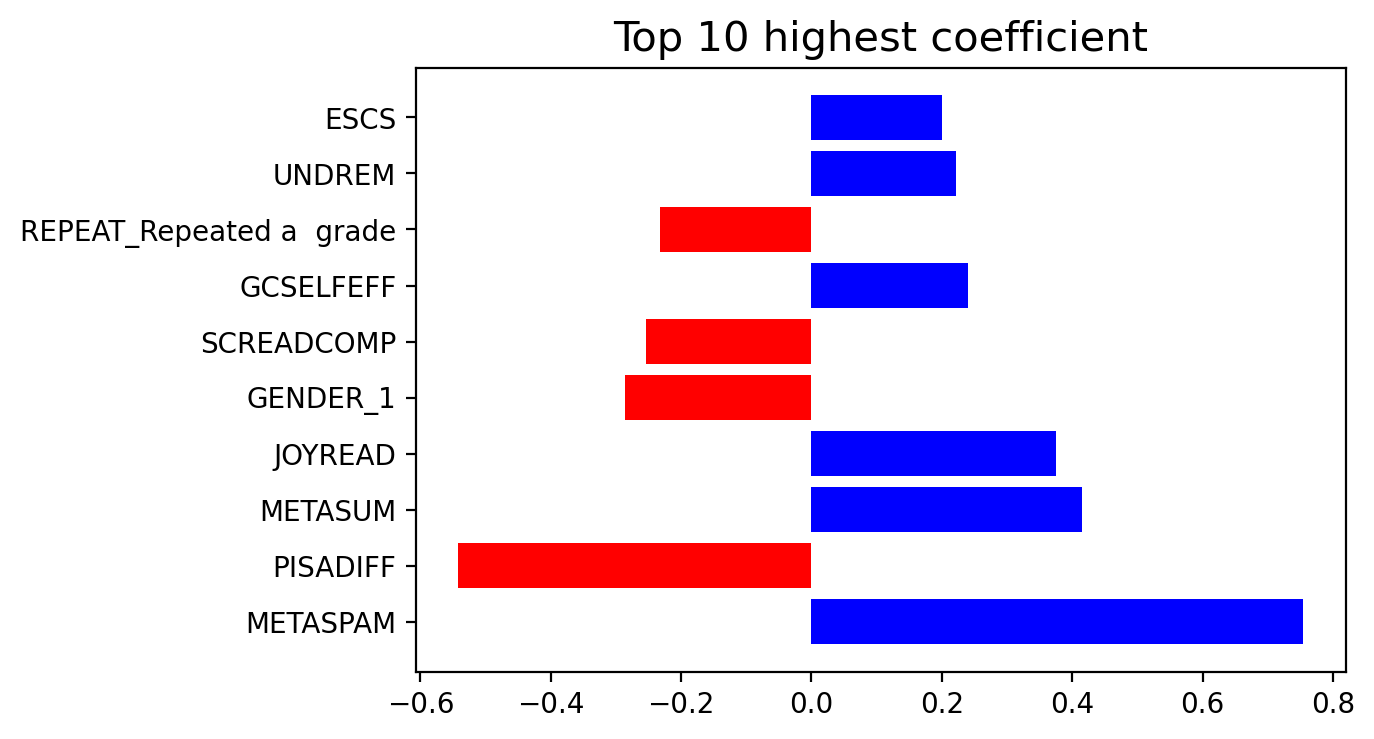

In [35]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(logreg_coef.loc[['METASPAM', 'PISADIFF', 'METASUM', 'JOYREAD', 'GENDER_1', 'SCREADCOMP',
       'GCSELFEFF', 'REPEAT_Repeated a  grade', 'UNDREM', 'ESCS']].index,logreg_coef.loc[['METASPAM', 'PISADIFF', 'METASUM', 'JOYREAD', 'GENDER_1', 'SCREADCOMP',
       'GCSELFEFF', 'REPEAT_Repeated a  grade', 'UNDREM', 'ESCS']][0],color=logreg_coef.loc[['METASPAM', 'PISADIFF', 'METASUM', 'JOYREAD', 'GENDER_1', 'SCREADCOMP',
       'GCSELFEFF', 'REPEAT_Repeated a  grade', 'UNDREM', 'ESCS']]['color'])
plt.title('Top 10 highest coefficient',size=15)

In [50]:
ebm = ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['PAREDINT', 'HISEI', 'ESCS',
                                             'UNDREM', 'METASUM', 'METASPAM',
                                             'HOMEPOS', 'HEDRES', 'ICTRES',
                                             'JOYREAD', 'SCREADCOMP',
                                             'SCREADDIFF', 'PISADIFF',
                                             'GCSELFEFF', 'AWACOM',
                                             'Is_FISCED_5A,6_1',
                                             'ISCEDL_ISCED level 3',
                                             'ISCEDL_ISCED level 4',
                                             'IMMIG_Native',
                                             'IMMIG_Second-Generation',
                                             'REPEAT_Repeated a  grade',
                                             'GENDER_1',
                                             'SCREADCOMP x SCRE...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction', ...])

In [51]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)


In [52]:
ebm.score(X_train, y_train),ebm.score(X_test, y_test)

(0.8115282518012893, 0.7585421412300684)

In [53]:
preds_ebm = ebm.predict(X_test)

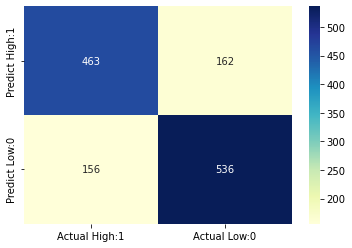

In [54]:
cm_ebm = confusion_matrix(y_test, preds_ebm)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [55]:
print(classification_report(y_test, preds_ebm))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       625
           1       0.77      0.77      0.77       692

    accuracy                           0.76      1317
   macro avg       0.76      0.76      0.76      1317
weighted avg       0.76      0.76      0.76      1317



In [42]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
param_test = {'learning_rate': [0.001,0.005,0.01,0.03],
              'interactions': [5,10,15],
              'max_interaction_bins': [10,15,20],
              'max_rounds': [5000,10000,15000,20000],
              'min_samples_leaf': [2,3,5],
              'max_leaves': [3,5,10]}
n_HP_points_to_test=10
ebm_clf =ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns, n_jobs=-1)
ebm_gs = RandomizedSearchCV(
    estimator=ebm_clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring="roc_auc",
    cv=3,
    refit=True,
    random_state=314,
    verbose=False,
)


In [43]:
ebm_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=ExplainableBoostingClassifier(feature_names=Index(['PAREDINT', 'HISEI', 'ESCS', 'UNDREM', 'METASUM', 'METASPAM', 'HOMEPOS',
       'HEDRES', 'ICTRES', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF', 'PISADIFF',
       'GCSELFEFF', 'AWACOM', 'Is_FISCED_5A,6_1', 'ISCEDL_ISCED level 3',
       'ISCEDL_ISCED level 4', 'IMMIG_Native', 'IMMIG_Second-Generation',
       'REPEAT_Repeated a  grade', 'GENDER_1'],
      dtype='object'),
                                                           n_jobs=-1),
                   param_distributions={'interactions': [5, 10, 15],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.03],
                                        'max_interaction_bins': [10, 15, 20],
                                        'max_leaves': [3, 5, 10],
                                        'max_rounds': [5000, 10000, 15000,
                                                       20000],
                                        'min_samples_leaf': [2, 3, 5]},
                   random_state=314, scoring='roc_auc', verbose=False)

In [ ]:
#y_train = le.fit_transform(y_train)
#y_test = le.fit_transform(y_test)

In [46]:
ebm_gs.best_params_

{'min_samples_leaf': 3,
 'max_rounds': 20000,
 'max_leaves': 5,
 'max_interaction_bins': 20,
 'learning_rate': 0.005,
 'interactions': 15}

In [47]:
preds_ebm_gs = ebm_gs.predict(X_test)

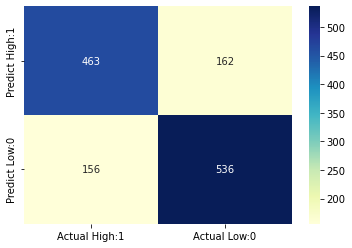

In [48]:
cm_ebm_gs = confusion_matrix(y_test, preds_ebm_gs)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm_gs, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [49]:
print(classification_report(y_test, preds_ebm_gs))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       625
           1       0.77      0.77      0.77       692

    accuracy                           0.76      1317
   macro avg       0.76      0.76      0.76      1317
weighted avg       0.76      0.76      0.76      1317



In [56]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

rfc.fit(X_train, y_train)

# Predict on the test set results

preds_rfc = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. 
      format(accuracy_score(y_test, preds)))

Model accuracy score with 100 decision-trees : 0.7555


In [57]:
#Find important features with Random Forest model 

In [58]:
# view the feature scores

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

METASPAM                    0.132669
ESCS                        0.096595
METASUM                     0.085325
PISADIFF                    0.080105
HOMEPOS                     0.074019
JOYREAD                     0.073113
GCSELFEFF                   0.064221
ICTRES                      0.054460
AWACOM                      0.052292
HISEI                       0.047661
SCREADDIFF                  0.047294
UNDREM                      0.046284
SCREADCOMP                  0.040418
HEDRES                      0.039923
PAREDINT                    0.019291
GENDER_1                    0.012490
Is_FISCED_5A,6_1            0.011153
IMMIG_Native                0.008333
IMMIG_Second-Generation     0.006520
REPEAT_Repeated a  grade    0.006188
ISCEDL_ISCED level 3        0.001386
ISCEDL_ISCED level 4        0.000260
dtype: float64

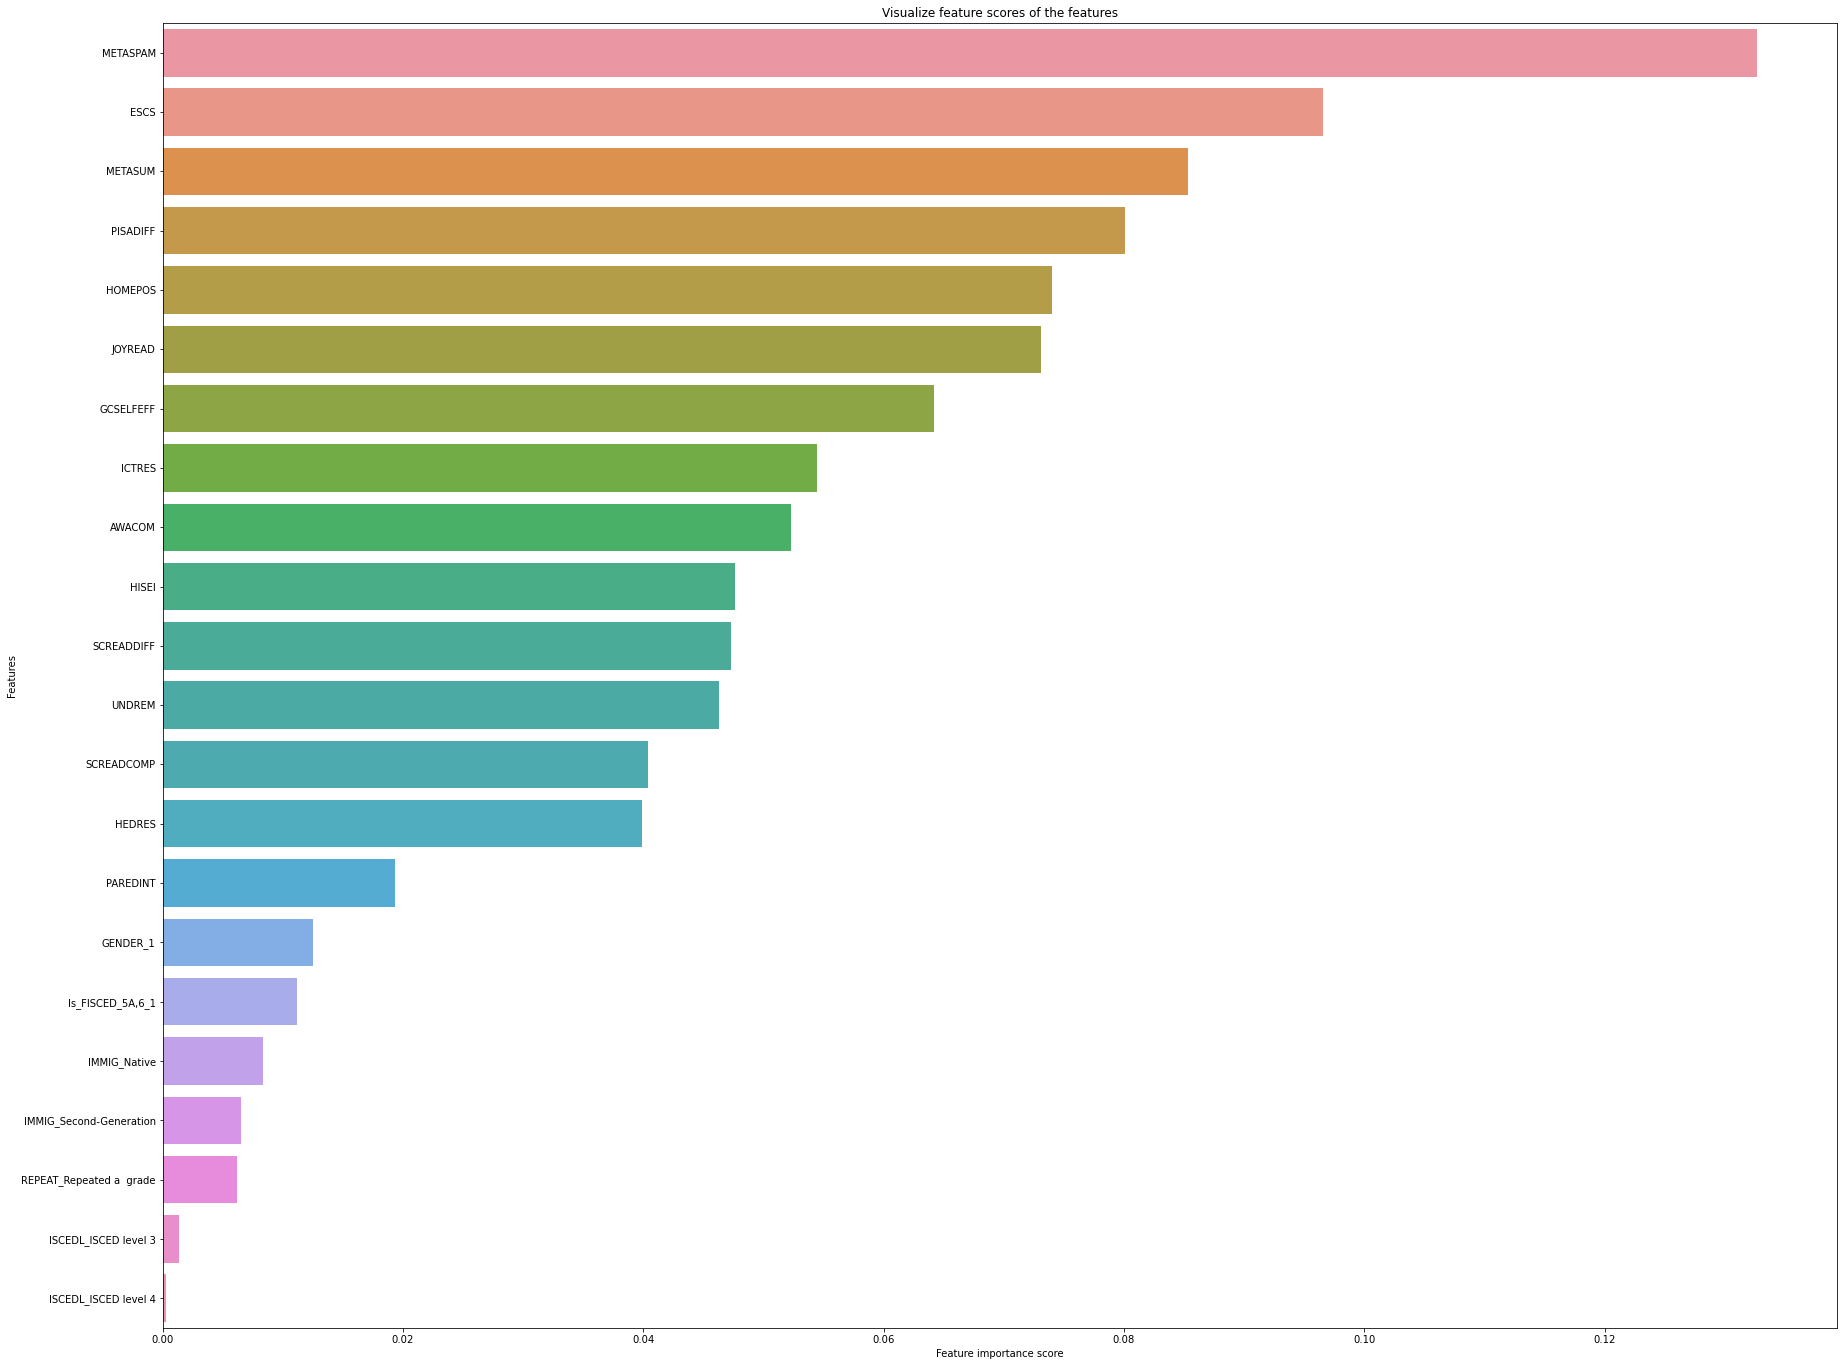

In [60]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train_singapore)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

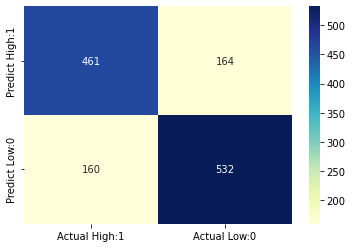

In [61]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_rfc, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [62]:
print(classification_report(y_test, preds_rfc))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       625
           1       0.76      0.77      0.77       692

    accuracy                           0.75      1317
   macro avg       0.75      0.75      0.75      1317
weighted avg       0.75      0.75      0.75      1317



In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [64]:
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 4)
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [65]:
preds_xgb = xgb.predict(X_test_sc)

In [66]:
# view the feature scores

feature_scores = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

METASPAM                    0.241831
PISADIFF                    0.087762
REPEAT_Repeated a  grade    0.086940
METASUM                     0.064754
IMMIG_Second-Generation     0.059918
GENDER_1                    0.043473
ESCS                        0.036235
UNDREM                      0.033993
JOYREAD                     0.030750
IMMIG_Native                0.029448
Is_FISCED_5A,6_1            0.028792
GCSELFEFF                   0.028576
HEDRES                      0.028331
AWACOM                      0.027709
HISEI                       0.027636
HOMEPOS                     0.027385
PAREDINT                    0.027344
SCREADDIFF                  0.027305
ICTRES                      0.025965
SCREADCOMP                  0.024017
ISCEDL_ISCED level 3        0.011837
ISCEDL_ISCED level 4        0.000000
dtype: float32

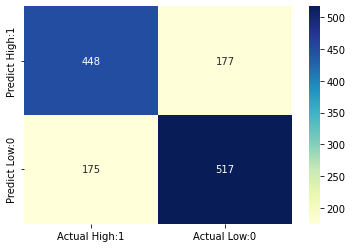

In [67]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_xgb, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [68]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       625
           1       0.74      0.75      0.75       692

    accuracy                           0.73      1317
   macro avg       0.73      0.73      0.73      1317
weighted avg       0.73      0.73      0.73      1317



In [69]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_sc)

C:\Users\science01\Anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [72]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[0,:])

In [73]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[:1000,:])

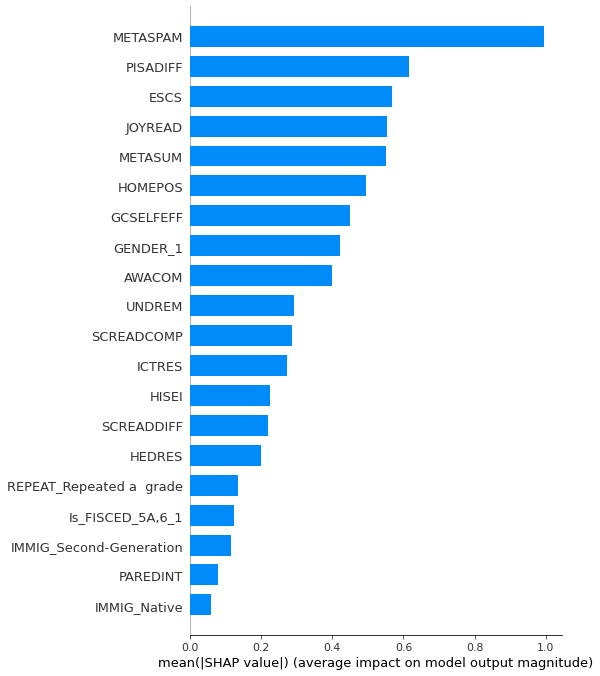

In [74]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names= X_train.columns)

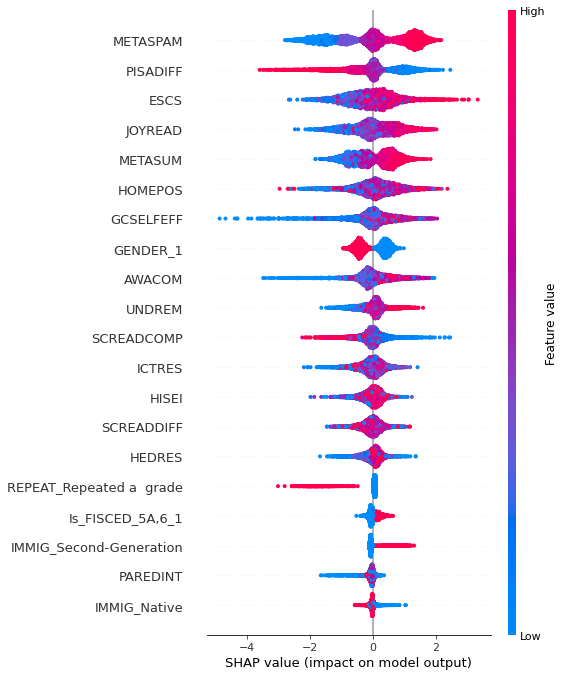

In [75]:
shap.summary_plot(shap_values, X_train)

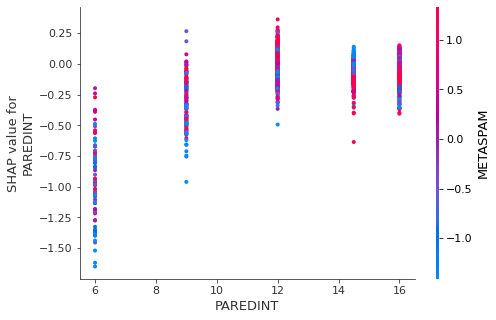

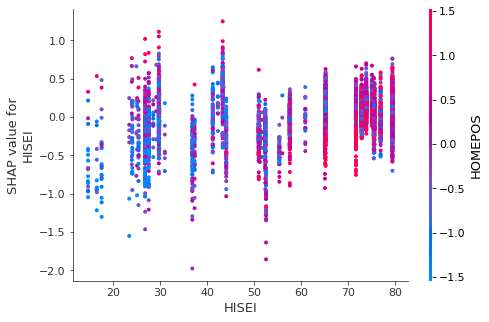

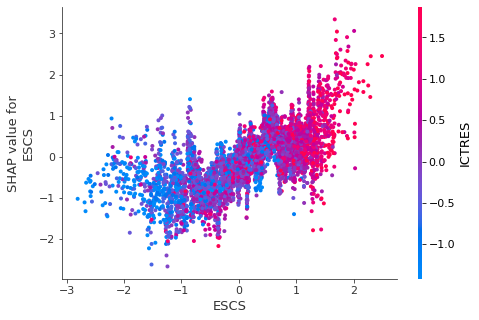

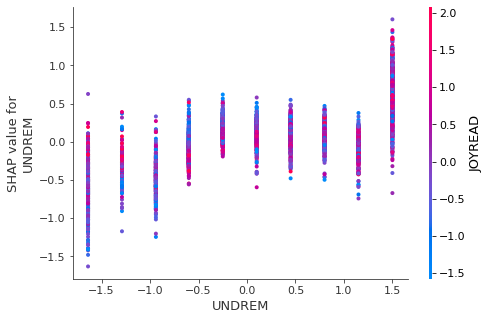

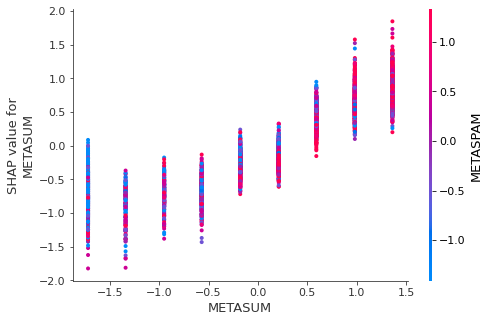

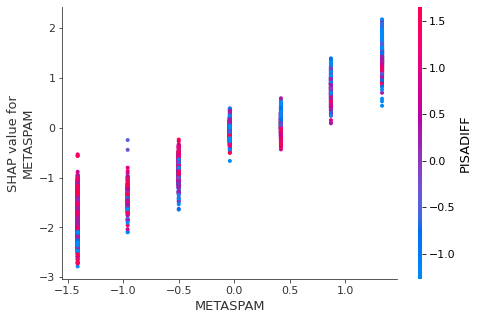

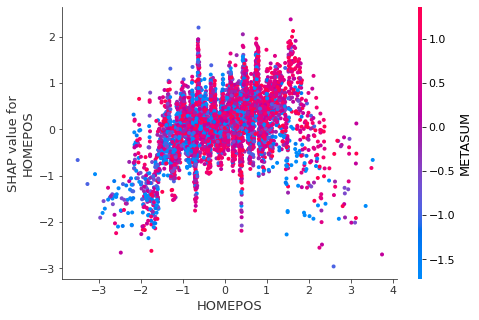

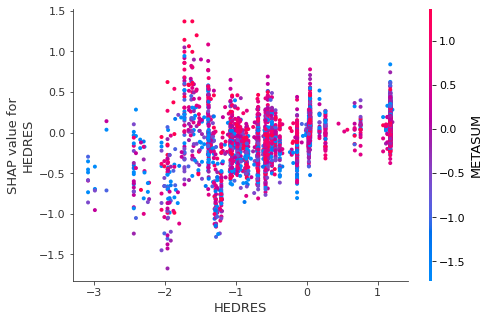

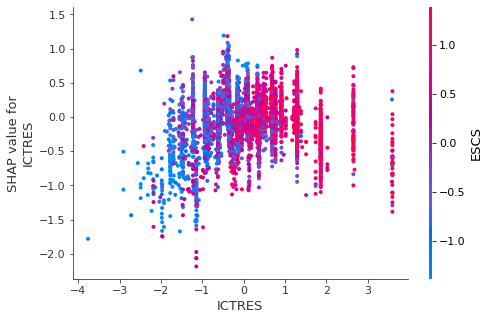

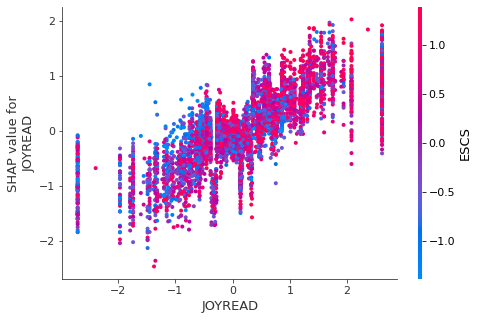

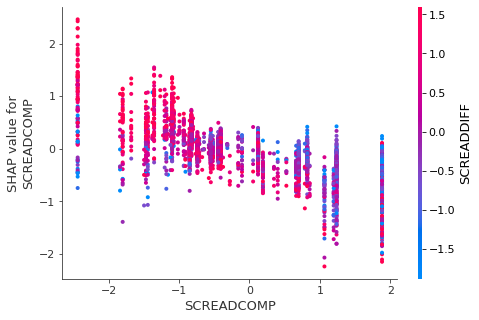

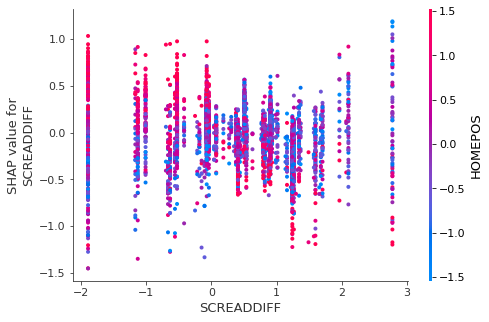

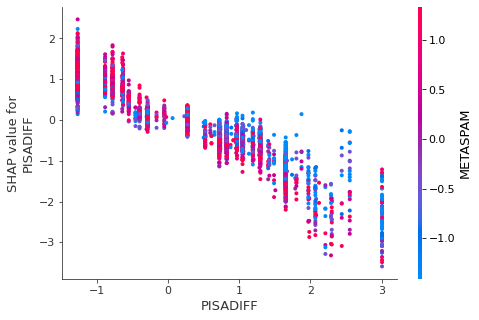

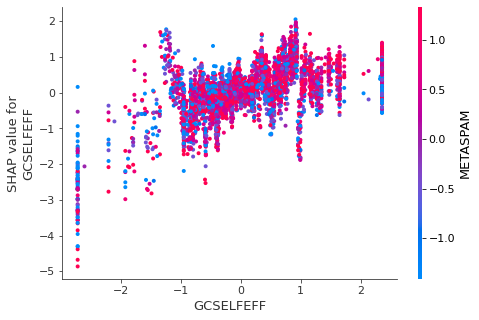

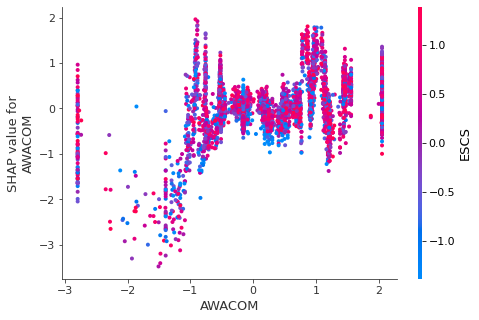

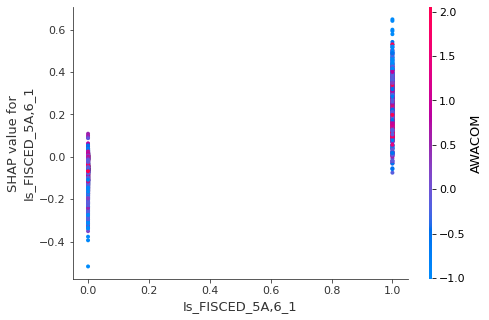

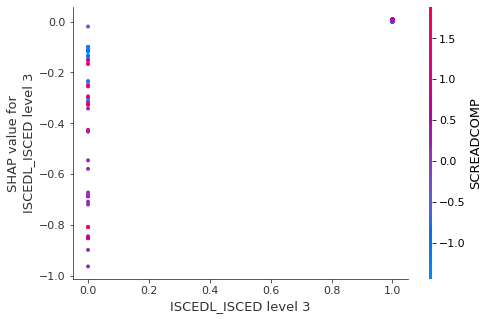

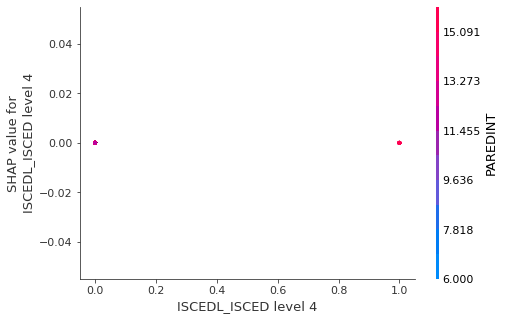

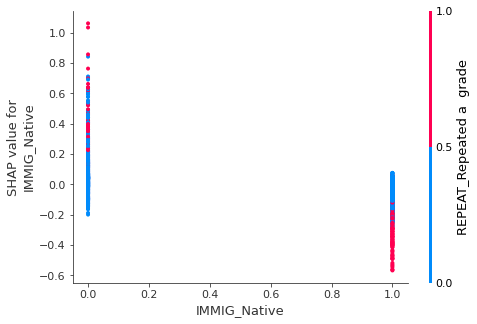

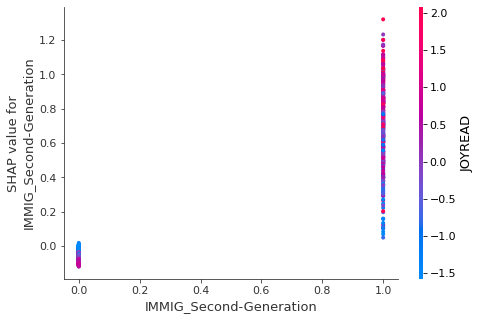

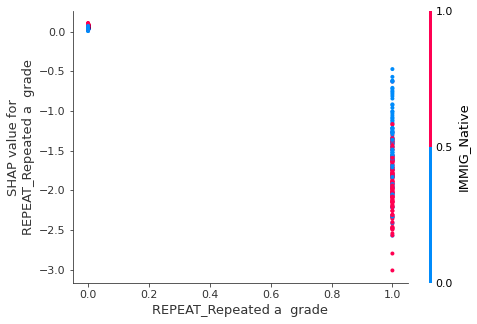

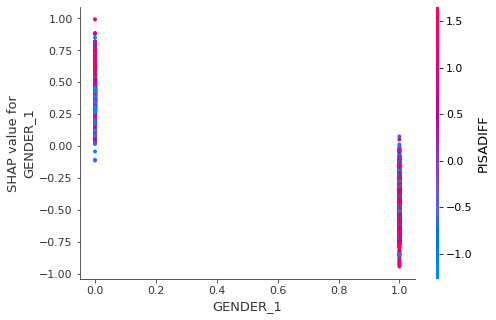

In [76]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)